# Search for available data

Before downloading satellite data it is important to know exactly which data is available and what kind of properties it has. Sentinel Hub offers multiple services to search collections of data:

- [Catalog API](#Sentinel-Hub-Catalog-API)
- [Web Feature Service](#Web-Feature-Service-(WFS))
- [Opensearch service](#Sentinel-Hub-Opensearch)

In this example tutorial we will show how to use each of the services.

Some general imports:

In [1]:
%matplotlib inline

import datetime as dt

import numpy as np
import matplotlib.pyplot as plt

from sentinelhub import SHConfig, BBox, CRS, DataCollection

## Sentinel Hub Catalog API

Catalog API is the main service with the most configurable search options. It supports searches over all available data collections and provides the most information about each item in a collection. The implementation is based on [STAC REST API specifications](https://stacspec.org/).

More information about the service is available in:

- [Documentation](https://docs.sentinel-hub.com/api/latest/api/catalog)
- [API definition](https://docs.sentinel-hub.com/api/latest/reference/#tag/Capabilities)


### Prerequisites

BYOC API requires Sentinel Hub account. Please see [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html) how to set up your configuration.

In [2]:
config = SHConfig()

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub Catalog API, please provide the credentials (client ID and client secret).")

### Available data collections

In the first, step let's initialize a `SentinelHubCatalog` class and check basic service info:

In [3]:
from sentinelhub import SentinelHubCatalog


catalog = SentinelHubCatalog(config=config)

catalog.get_info()

{'stac_version': '0.9.0',
 'stac_extensions': [],
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v0.9.0 implementation by Sentinel Hub',
 'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/',
   'rel': 'self'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/conformance',
   'rel': 'conformance'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/search',
   'rel': 'search'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections',
   'rel': 'data'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-1-grd',
   'rel': 'child'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l2a',
   'rel': 'child'}]}

Each data collection has its own catalog collection. The default collections are already listed in the info response. Information about all available collections, including user-defined [BYOC](https://docs.sentinel-hub.com/api/latest/data/byoc/) and [batch](https://docs.sentinel-hub.com/api/latest/api/batch/) collections, can be obtained with the next example.

The following code will obtain information about all collections but then filter out BYOC and batch collections:

In [4]:
collections = catalog.get_collections()

collections = [collection for collection in collections if not collection['id'].startswith(('byoc', 'batch'))]

collections

[{'stac_version': '0.9.0',
  'id': 'sentinel-2-l1c',
  'title': 'Sentinel 2 L1C',
  'description': 'Sentinel 2 imagery processed to level 1C',
  'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c',
    'rel': 'self'},
   {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c/items',
    'rel': 'items'}],
  'license': 'license',
  'providers': [{'name': 'ESA',
    'roles': ['producer'],
    'url': 'https://esa.int/'},
   {'name': 'AWS', 'roles': ['host'], 'url': 'https://aws.amazon.com/'},
   {'name': 'Sinergise',
    'roles': ['processor'],
    'url': 'https://www.sinergise.com/'}],
  'extent': {'spatial': {'bbox': [-180.0, -56.0, 180.0, 83.0]},
   'temporal': {'interval': ['2015-11-01T00:00:00Z', None]}}},
 {'stac_version': '0.9.0',
  'id': 'sentinel-1-grd',
  'title': 'Sentinel 1 GRD',
  'description': 'Sentinel 1 Ground Range Detected Imagery',
  'links': [{'href': 'https://services.sentinel-hub.com/api/v1/c

Information about a single collection can also be obtained with the following method:

In [5]:
catalog.get_collection(DataCollection.SENTINEL1_EW)

{'stac_version': '0.9.0',
 'id': 'sentinel-1-grd',
 'title': 'Sentinel 1 GRD',
 'description': 'Sentinel 1 Ground Range Detected Imagery',
 'links': [{'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-1-grd',
   'rel': 'self'},
  {'href': 'https://services.sentinel-hub.com/api/v1/catalog/collections/sentinel-1-grd/items',
   'rel': 'items'}],
 'license': 'license',
 'providers': [{'name': 'ESA',
   'roles': ['producer'],
   'url': 'https://esa.int/'},
  {'name': 'AWS', 'roles': ['host'], 'url': 'https://aws.amazon.com/'},
  {'name': 'Sinergise',
   'roles': ['processor'],
   'url': 'https://www.sinergise.com/'}],
 'extent': {'spatial': {'bbox': [-180.0, -85.0, 180.0, 85.0]},
  'temporal': {'interval': ['2017-01-01T00:00:00Z', None]}}}

We can see that the list of available collections contains only some of the collections [supported by Sentinel Hub](https://docs.sentinel-hub.com/api/latest/data/). That is because some types of satellite data are not available in the main deployment of Sentinel Hub service. To access catalogs of other deployments we have to set a base URL of a deployment in the configuration object and provide it to Catalog interface:

In [6]:
uswest_config = SHConfig()
uswest_config.sh_base_url = 'https://services-uswest2.sentinel-hub.com'

uswest_catalog = SentinelHubCatalog(config=uswest_config)

uswest_catalog.get_info()

{'stac_version': '0.9.0',
 'stac_extensions': [],
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v0.9.0 implementation by Sentinel Hub',
 'links': [{'href': 'https://services-uswest2.sentinel-hub.com/api/v1/catalog/',
   'rel': 'self'},
  {'href': 'https://services-uswest2.sentinel-hub.com/api/v1/catalog/conformance',
   'rel': 'conformance'},
  {'href': 'https://services-uswest2.sentinel-hub.com/api/v1/catalog/search',
   'rel': 'search'},
  {'href': 'https://services-uswest2.sentinel-hub.com/api/v1/catalog/collections',
   'rel': 'data'},
  {'href': 'https://services-uswest2.sentinel-hub.com/api/v1/catalog/collections/landsat-8-l1c',
   'rel': 'child'},
  {'href': 'https://services-uswest2.sentinel-hub.com/api/v1/catalog/collections/modis',
   'rel': 'child'}]}

In many cases, service deployments are already configured for each `DataCollection` enum item. With the following code we can access a catalog containing Sentinel-5p data:

In [7]:
creodias_config = SHConfig()
creodias_config.sh_base_url = DataCollection.SENTINEL5P.service_url

creodias_catalog = SentinelHubCatalog(config=creodias_config)

creodias_catalog.get_info()

{'stac_version': '0.9.0',
 'stac_extensions': [],
 'id': 'sentinel-hub',
 'title': 'Sentinel Hub STAC catalog',
 'description': 'STAC v0.9.0 implementation by Sentinel Hub',
 'links': [{'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/',
   'rel': 'self'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/conformance',
   'rel': 'conformance'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/search',
   'rel': 'search'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/collections',
   'rel': 'data'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l1c',
   'rel': 'child'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/collections/sentinel-3-olci',
   'rel': 'child'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/collections/sentinel-3-slstr',
   'rel': 'child'},
  {'href': 'https://creodias.sentinel-hub.com/api/v1/catalog/collections/sentinel-2-l2a',
   'rel': 'child'},
  {'h

### Search features in catalog collections

Once we have successfully initialized a catalog object we can search for features inside a specific collection. If we have an ID of a satellite tile we can search for its information like this:

In [8]:
catalog.get_feature(
    DataCollection.SENTINEL2_L2A,
    'S2A_MSIL2A_20210125T073201_N0214_R049_T39TWK_20210125T105105'
)

{'stac_version': '0.9.0',
 'stac_extensions': ['eo', 'projection'],
 'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TWK_20210125T105105',
 'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:OGC::CRS84'}},
  'coordinates': [[[[50.99975828238186, 45.15382824779532],
     [50.99976235468337, 44.16537549736596],
     [52.37288170686682, 44.15712570690993],
     [52.39639823709577, 45.14529082814174],
     [50.99975828238186, 45.15382824779532]]]]},
 'bbox': [50.99975828238186,
  44.15712570690993,
  52.39639823709577,
  45.15382824779532],
 'properties': {'datetime': '2021-01-25T07:37:20Z',
  'platform': 'sentinel-2a',
  'instruments': ['msi'],
  'constellation': 'sentinel-2',
  'eo:gsd': 10,
  'eo:cloud_cover': 0.59,
  'eo:bands': [{'name': 'B01',
    'common_name': 'coastal',
    'center_wavelength': 0.4427,
    'full_width_half_max': 0.021},
   {'name': 'B02',
    'common_name': 'blue',
    'center_wavelength': 

For any more advanced search we can use `SentinelHubCatalog.search` method. The method always requires a data collection, time interval and a bounding box or a geometry. Additionally, we can define various STAC-based query filters which are described in [documentation](https://docs.sentinel-hub.com/api/latest/api/catalog/) and [API definition](https://docs.sentinel-hub.com/api/latest/reference/#operation/postSearchSTAC).

In our case, we will filter all satellite tiles with more than `5%` cloud coverage. To reduce the size of downloaded responses we will also filter fields that will be returned in the response.

In [9]:
caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)
time_interval = '2020-12-10', '2021-02-01'

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=caspian_sea_bbox,
    time=time_interval,
    query={
        "eo:cloud_cover": {
            "lt": 5
        }
    },
    fields={
        "include": [
            "id",
            "properties.datetime",
            "properties.eo:cloud_cover"
        ],
        "exclude": []
    }
    
)

results = list(search_iterator)
print('Total number of results:', len(results))

results

Total number of results: 11


[{'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TVK_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:23Z', 'eo:cloud_cover': 3.84}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TWK_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:20Z', 'eo:cloud_cover': 0.59}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TVL_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:09Z', 'eo:cloud_cover': 0.0}},
 {'id': 'S2A_MSIL2A_20210125T073201_N0214_R049_T39TWL_20210125T105105',
  'properties': {'datetime': '2021-01-25T07:37:05Z', 'eo:cloud_cover': 0.05}},
 {'id': 'S2A_MSIL2A_20210105T073311_N0214_R049_T39TVK_20210105T100353',
  'properties': {'datetime': '2021-01-05T07:37:23Z', 'eo:cloud_cover': 0.33}},
 {'id': 'S2A_MSIL2A_20210105T073311_N0214_R049_T39TVL_20210105T100353',
  'properties': {'datetime': '2021-01-05T07:37:09Z', 'eo:cloud_cover': 3.42}},
 {'id': 'S2A_MSIL2A_20201226T073321_N0214_R049_T39TWK_20201226T103718',
  'properties': {'datet

### Combine Catalog API with Process API

With Catalog API we were able to get information all satellites tiles for a given bounding box and time interval. Let's see how we can use this information with [Process API](./process_request.ipynb) to download data for all acquisitions.

We can see that many timestamps differ only for a few seconds. That is because they are from tiles in the same orbit acquisition. Because of that, we want to join them together in a single timestamp.

In [10]:
from sentinelhub import SentinelHubRequest, filter_times, bbox_to_dimensions, \
    MimeType, SentinelHubDownloadClient


time_difference = dt.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

unique_acquisitions

[datetime.datetime(2020, 12, 11, 7, 37, 6, tzinfo=tzutc()),
 datetime.datetime(2020, 12, 26, 7, 37, 4, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 5, 7, 37, 9, tzinfo=tzutc()),
 datetime.datetime(2021, 1, 25, 7, 37, 5, tzinfo=tzutc())]

Next, we create a Process API request for each acquisition:

In [11]:
false_color_evalscript = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B04", "B08"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B08, sample.B04, sample.B03];
    }
"""


process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=false_color_evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=(timestamp - time_difference, timestamp + time_difference)
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.PNG)
        ],
        bbox=caspian_sea_bbox,
        size=bbox_to_dimensions(caspian_sea_bbox, 100),
        config=config
    )
    process_requests.append(request)

In order to efficiently download data for all requests in parallel, we extract download information and pass it to a download client.

In [12]:
%%time

client = SentinelHubDownloadClient(config=config)

download_requests = [request.download_list[0] for request in process_requests]

data = client.download(download_requests)

data[0].shape

CPU times: user 286 ms, sys: 91 ms, total: 377 ms
Wall time: 2.99 s


(567, 861, 3)

Downloaded images nicely show how the ice cover has been changing over Caspian Sea during winter.

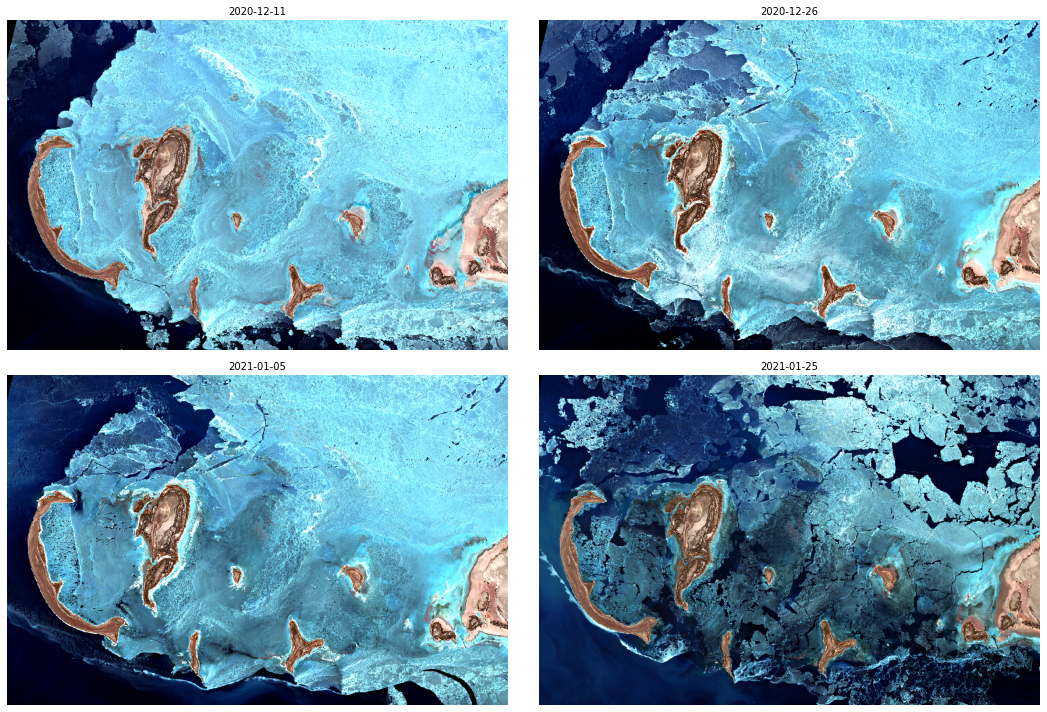

In [13]:
ncols, nrows = 2, 2

fig, axis = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(15, 10),
    subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
)

for idx, (image, timestamp) in enumerate(zip(data, unique_acquisitions)):
    ax = axis[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(timestamp.date().isoformat(), fontsize=10)

plt.tight_layout()

## Web Feature Service (WFS)

This is an OGC-based service that allows searching with a bounding box and time interval. Instead of OAuth credentials, it requires an instance ID of a configuration created in [Sentinel Hub Dashboard](https://apps.sentinel-hub.com/dashboard/#/configurations). For each data collection that you search you have to make sure that you have at least one layer with that data collection defined in a configuration that you are using.

More information can be found in [WFS service documentation](https://www.sentinel-hub.com/develop/api/ogc/standard-parameters/wfs/).

In [14]:
from sentinelhub import WebFeatureService

# In case you put the credentials into the configuration file you can leave this unchanged
INSTANCE_ID = ''

config = SHConfig()
if INSTANCE_ID:
    config.instance_id = INSTANCE_ID

Let's search with the same parameters used in the Catalog API example above. We obtain the same number of results but with a bit different types of information in properties.

In [15]:
caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)
time_interval = '2020-12-10', '2021-02-01'

wfs_iterator = WebFeatureService(
    caspian_sea_bbox,
    time_interval,
    data_collection=DataCollection.SENTINEL2_L2A,
    maxcc=0.05,
    config=config
)


results = list(wfs_iterator)
print('Total number of results:', len(results))

results[0]

Total number of results: 11


{'type': 'Feature',
 'geometry': {'type': 'MultiPolygon',
  'crs': {'type': 'name',
   'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}},
  'coordinates': [[[[49.93785647716704, 45.148889056112026],
     [49.74031200696015, 44.56043233398102],
     [49.748895259607195, 44.15852444737688],
     [51.122062001896936, 44.165310291207646],
     [51.12415365570594, 45.15376076806522],
     [49.93785647716704, 45.148889056112026]]]]},
 'properties': {'id': 'S2A_OPER_MSI_L2A_TL_EPAE_20210125T105105_A029218_T39TVK_N02.14',
  'date': '2021-01-25',
  'time': '07:37:23',
  'path': 's3://sentinel-s2-l2a/tiles/39/T/VK/2021/1/25/0',
  'crs': 'EPSG:32639',
  'mbr': '399960,4890240 509760,5000040',
  'cloudCoverPercentage': 3.84}}

## Sentinel Hub Opensearch

Sentinel Hub Opensearch is a service based on Opensearch standard. It doesn't require any authentication but it supports only Sentinel-2 L1C collection.

More information can be found in [Opensearch service documentation](https://www.sentinel-hub.com/develop/community/opensearch-interface/).

We again use the same search parameters and obtain the same number of results.

In [16]:
from sentinelhub import get_area_info


caspian_sea_bbox = BBox([49.9604, 44.7176, 51.0481, 45.2324], crs=CRS.WGS84)
time_interval = '2020-12-10', '2021-02-01'

opensearch_iterator = get_area_info(
    caspian_sea_bbox, 
    time_interval,
    maxcc=0.05
)

results = list(opensearch_iterator)
print('Total number of results:', len(results))

results[0]

Total number of results: 11


{'type': 'Feature',
 'id': '9016971b-5ecc-52db-bfc0-c460343edaee',
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[49.937856477167, 45.148889056112],
     [49.74031200696, 44.560432333981],
     [49.748895259607, 44.158524447377],
     [51.122062001897, 44.165310291208],
     [51.124153655706, 45.153760768065],
     [49.937856477167, 45.148889056112]]]]},
 'properties': {'collection': 'Sentinel2',
  'license': {'licenseId': 'unlicensed',
   'hasToBeSigned': 'never',
   'grantedCountries': None,
   'grantedOrganizationCountries': None,
   'grantedFlags': None,
   'viewService': 'public',
   'signatureQuota': -1,
   'description': {'shortName': 'No license'}},
  'productIdentifier': 'S2A_OPER_MSI_L1C_TL_EPAE_20210125T091155_A029218_T39TVK_N02.09',
  'parentIdentifier': None,
  'title': 'S2A_OPER_MSI_L1C_TL_EPAE_20210125T091155_A029218_T39TVK_N02.09',
  'description': None,
  'organisationName': None,
  'startDate': '2021-01-25T07:37:23Z',
  'completionDate': '2021-01-25T07:37: